# GAN Monet

In this notebook we will use the Generative Adversarial Networks, GAN, machine learning method to create Montesquieu still images. We will then submit those images to Kaggle and get a Memorization-informed Fréchet Inception Distance score.

A Generative Adversarial Network works by building two competing models. One model, the generator, creates an image, then the second model, the discriminator, indicates whether the image is real or fake. If it is fake, the discriminator sends information back to the generator, which updates its parameters and generates another image.

A link the Github Repo is [here](https://github.com/poreeves/Monet-GAN)

Let's load our data and modules and get started.

In [1]:
pip install opendatasets

We are getting the data from [here](https://www.kaggle.com/competitions/gan-getting-started/data).

We will be using the Tensorflow and Keras libraries.

In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape,Rescaling
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam


import numpy as np
import os
import time
from IPython import display

Let's load the data. You will need to have a Kaggle account and API key to load the data. Here are some [instructions](https://github.com/Kaggle/kaggle-api).

In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/competitions/gan-getting-started/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: philreeves
Your Kaggle Key: ··········


100%|██████████| 367M/367M [00:18<00:00, 20.9MB/s]



Extracting archive ./gan-getting-started/gan-getting-started.zip to ./gan-getting-started


# EDA

In [ ]:
print(os.listdir('./gan-getting-started'))
print(len(os.listdir('./gan-getting-started/monet_tfrec')), len(os.listdir('./gan-getting-started/photo_tfrec')))
print(len(os.listdir('./gan-getting-started/monet_jpg')), len(os.listdir('./gan-getting-started/photo_jpg')))




['photo_jpg', 'monet_jpg', 'photo_tfrec', 'monet_tfrec']
5 20
300 7038


Our data has four folders. We will be using the photo and Monet  tfrec folders.

Now let's load the images.

In [ ]:
Monet_files = tf.io.gfile.glob(str('/content/drive/MyDrive/GAN Monet/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(Monet_files))
#/content/drive/MyDrive/GAN Monet/monet_tfrec
Photo_files = tf.io.gfile.glob('./gan-getting-started/photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(Photo_files))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


Here is a function that will help us use read the tfrec images.

In [ ]:
img_size = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*img_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [ ]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

In [ ]:
monet_ds = load_dataset(Monet_files, labeled=True).batch(1)
photo_ds = load_dataset(Photo_files, labeled=True).batch(1)

In [ ]:
monet_ds

In [ ]:
photo_ds

Now the images have been loaded, decoded, and formatted.

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

Let's plot some of the images.

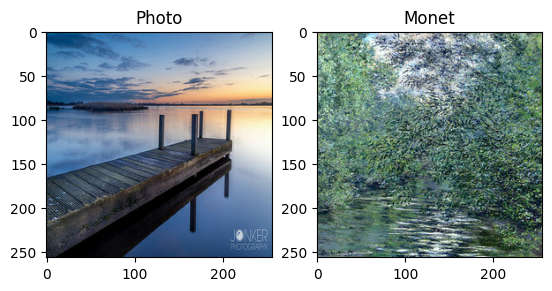

In [ ]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

Now that we've see the data. Let's get started on the model.

# GAN Model

Our GAN model is going to have two distinct features, the generator and the discriminator. We will then set those two functions against each other to create out Monet fakes.

First let's build the generator. The generator model will start by taking some random of some random noise and then uses convolution transpose layers to build out the image. The discriminator will do the opposite.

In [ ]:
def Generator():
    model = Sequential()
    n_nodes = 16 * 16 * 512
    model.add(Dense(n_nodes, input_shape=(100,)))
    model.add(Reshape((16, 16, 512)))

    model.add(Conv2DTranspose(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(3, kernel_size=(3, 3), activation='tanh', strides=(1, 1), padding='same'))

    return model

Now that our model is defined, let's create one and take a look at it.

In [ ]:
generator = Generator()

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 131072)            13238272  
                                                                 
 reshape (Reshape)           (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 256)       1179904   
 anspose)                                                        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 128)       295040    
 Transpose)                                                      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0

Our model consists of 5 convolution transpose layers, building an image with the shape 256 X 256. Let's put some random numbers into our model and see if it can produce an image.

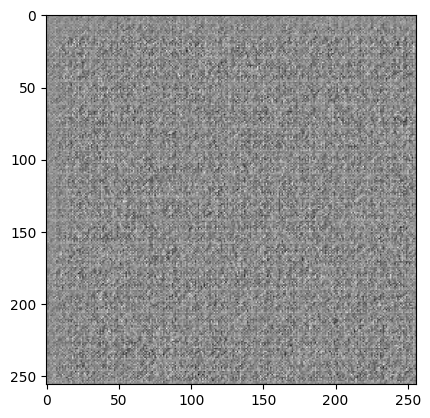

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Our generator successfully produced an image, albeit not a very nice one.

Our next step is to create the discriminator. This model will take the output of the generator and break it down using convolution layers. It will output a binary fake or real.

In [ ]:
def Discriminator():
    model = Sequential()


    model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(2, 2), padding='same', input_shape=[256, 256, 3]))
    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))


    model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))


    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
discriminator = Discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                      

Our discriminator model has 4 convolution layers and an output layer that produces a decision whether the image is real or fake.

In [ ]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49998885]], shape=(1, 1), dtype=float32)


Now it is time to set our models against each other. Since we are looking for a yes or no, we will use binary cross entropy as our loss function.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


We are using an Adam optimizer with a learn rate of 0.0001.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 10
BATCH_SIZE = 32
noise_dim = 100
shape_dim = [256,256,3]
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

We set our train step function to set the the generator and discriminator against each other. We record their loss and use that to update the parameters of the generator model.

In [ ]:
@tf.function
def train_step(image_batch, train_dim):
    noise = tf.random.normal([1,train_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_image = generator(noise, training=True)

        discriminator_pred_gen = discriminator(generated_image, training=True)

        discriminator_pred_ori= discriminator(image_batch, training=True)


        discriminator_loss = cross_entropy(tf.ones_like(discriminator_pred_ori),discriminator_pred_ori) + cross_entropy_loss(tf.zeros_like(discriminator_pred_gen), discriminator_pred_gen)
        generator_loss = cross_entropy(tf.ones_like(discriminator_pred_gen), discriminator_pred_gen)

    generator_grad = gen_tape.gradient(generator_loss, generator.trainable_variables)
    discriminator_grad = disc_tape.gradient(discriminator_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_grad,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_grad,discriminator.trainable_variables))

Now we define a function that will call the train step function multiple times.

In [ ]:
def train(dataset, epochs, train_dim=100):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, train_dim)

        print(f"Time for epoch {epoch+ 1} is : {time.time()-start}")

Let's set our generator to run for 50 epochs and feed it the Monet images.

In [ ]:
EPOCHS= 50
generator = Generator()
discriminator = Discriminator()
train(monet_ds,EPOCHS)

Time for epoch 1 is : 16.786851167678833
Time for epoch 2 is : 3.7239370346069336
Time for epoch 3 is : 3.6590383052825928
Time for epoch 4 is : 3.6869029998779297
Time for epoch 5 is : 4.019392490386963
Time for epoch 6 is : 3.6931753158569336
Time for epoch 7 is : 3.70382022857666
Time for epoch 8 is : 3.9090166091918945
Time for epoch 9 is : 3.8376834392547607
Time for epoch 10 is : 3.731421947479248
Time for epoch 11 is : 3.7362163066864014
Time for epoch 12 is : 4.104098558425903
Time for epoch 13 is : 3.7602572441101074
Time for epoch 14 is : 3.7758376598358154
Time for epoch 15 is : 5.953407049179077
Time for epoch 16 is : 4.021042585372925
Time for epoch 17 is : 3.8028175830841064
Time for epoch 18 is : 3.9228274822235107
Time for epoch 19 is : 4.037971258163452
Time for epoch 20 is : 3.820882558822632
Time for epoch 21 is : 3.835212469100952
Time for epoch 22 is : 4.09630012512207
Time for epoch 23 is : 3.853149652481079
Time for epoch 24 is : 3.867321252822876
Time for epoch 

Now it is time to see our results! This function will display the image we created.

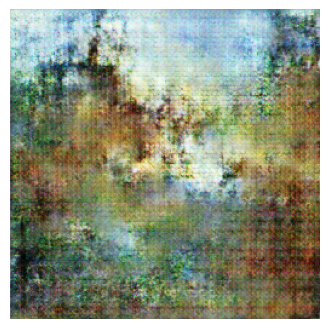

In [ ]:
def generate_images(r=1,c=1, train_dim=100, is_norm=False):
    plt.figure(figsize=(4*r,5*c))
    for i in range(1,1+r*c):
        noise = tf.random.normal([1,train_dim])
        plt.subplot(r,c,i)
        if(is_norm):
            plt.imshow(generator(noise)[0,:,:,:]*255)
        else:
            plt.imshow(generator(noise)[0,:,:,:]*0.5 + 0.5)
        plt.axis('off')
generate_images()

It looks impressionable to me.

In [ ]:
test1 = generator(noise)[0,:,:,:]*0.5 + 0.5

In [ ]:
test1.shape

TensorShape([256, 256, 3])

For our submission to Kaggle we need to submit jpeg images. This helper function will convert our tensor outputs of the generator into images we can turn in.

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

We need to create at least 7000 Monet style images. Let's get started!

This cell will run our trained generator function to create 7000 Monet style images and save them in my G drive. If you are using a local notebook, just update the image save path to where you would like your images saved.

In [ ]:
#for i in range(7000):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])
    #img = generator(noise)[0,:,:,:]*0.5 + 0.5
    #img = tensor_to_image(img)
    #img = img.convert('RGB')
    #img.save("/content/drive/MyDrive/GAN Monet/test/img" + str(i) + ".jpg")

In [ ]:
#print(len(os.listdir('/content/drive/MyDrive/GAN Monet/test/')))

7000


After submitting our generated images we scored a 132 on the  Memorization-informed Fréchet Inception Distance. We will discuss how that score is compared to other submission and how we might better improve our model in the conclusion.

# Conclusion

We successfully created a generative adversarial model. We defined and built both aspects of the model, the generator, and the discriminator. We then set them against each other to produce Monet style images. After generating 7000 images, our MFID score was 132. The lower the MFID score the better and on the Kaggle leaderboards we ranked at 68. The lowest score was 35. So, we definitely have room to improve this model.

In the future, we could try adjusting the activation functions, updating the normalization layers, and modifying the number of epochs.

# Refrences


*   https://www.kaggle.com/competitions/gan-getting-started/overview
*   https://developers.google.com/machine-learning/gan/gan_structure
*   https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
*   https://medium.com/@siraj.hatoum/gan-hyperparameter-tuning-with-keras-tuner-81e00ad1d6be
*   https://www.techtarget.com/searchenterpriseai/definition/Frechet-inception-distance-FID
*   https://towardsdatascience.com/generative-adversarial-networks-explained-34472718707a
*   https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
